# Classifying names with RNN

Classify few thousand surnames from 18 languages and predict the language based on the spelling

Data: https://download.pytorch.org/tutorial/data.zip

In [28]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

print(f"[DEVICE] {torch.get_default_device()}")

[DEVICE] cuda:0


## Preparing the data

In [29]:
import string
import unicodedata

allowed_characters = string.ascii_letters + ".,;'" + "_"
n_letters = len(allowed_characters)

# convert to unicode to ascii to limit the RNN input parameters
# eg. using one-hot encoding you need 128 parameters with ASCII
# while thousands parameters with Unicode
# So, the RNN training is faster and simpler
def unicodeToAscii(s):
    return ''.join(
        # decompose the combined chars
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )


In [30]:
word_test = "Ślusàrski"
print(f"[UNICODE] {word_test}")
print(f"[ASCII] {unicodeToAscii(word_test)}")


[UNICODE] Ślusàrski
[ASCII] Slusarski


# Name to tensor
Using one hot encoding, we represent chars as tensors, so tensors will have the size of the vocabulary

In [31]:
# get the letter index
def letterToIndex(letter):
    # if letter in unknown
    if letter not in allowed_characters:
        return allowed_characters.find('_')
    else:
        return allowed_characters.find(letter)

# word to tensor
def lineToTensor(line):
    # RNN, GRU and LTSM have this expected input shape
    # (seq_len, batch, input_size), where:
    # seq_len: number of steps in the network, 1 step is 1 letter
    # batch: sequences in parallel, 1 is for 1 letter at a time
    # input_size: size of vocabulary
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [32]:
print(f"[TEST] a:")
print(lineToTensor("a"))

print(f"[TEST] Ahn:")
print(lineToTensor("Ahn"))

[TEST] a:
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]], device='cuda:0')
[TEST] Ahn:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Prepare data

In [33]:
from io import open
import glob
import os
import time

import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):
    def __init__(self, data_dir):
        # metadata
        self.data_dir = data_dir
        self.load_time = time.localtime
        # set of all languages
        labels_set = set()
        # Names and languages by strings and tensors
        self.data = []
        self.data_tensors = []
        self.labels = []
        self.labels_tensors = []
        # read data from .txt
        text_files = glob.glob(os.path.join(data_dir, "*.txt"))
        for filename in text_files:
            label = os.path.splitext(os.path.basename(filename))[0]
            labels_set.add(label)
            lines = open(filename, encoding="utf-8").read().strip().split("\n")
            for name in lines:
                self.data.append(name)
                self.data_tensors.append(lineToTensor(name))
                self.labels.append(label)
        # labels to tensor
        self.labels_uniq = list(labels_set)
        for idx in range(len(self.labels)):
            # the tensor of the label is its index in the list of unique labels
            temp_tensor = torch.tensor([self.labels_uniq.index(self.labels[idx])], dtype=torch.long)
            self.labels_tensors.append(temp_tensor)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        data_item = self.data[idx]
        data_label = self.labels[idx]
        data_tensor = self.data_tensors[idx]
        label_tensor = self.labels_tensors[idx]

        return label_tensor, data_tensor, data_label, data_item

In [34]:
alldata = NamesDataset("./data/names")
print(f"[DATA] Loaded {len(alldata)} names")
print(f"[EXAMPLE]")
print(alldata[0])

[DATA] Loaded 20074 names
[EXAMPLE]
(tensor([0], device='cuda:0'), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 1., 

In [35]:
# here we are using Generator to set the device as gpu
train_set, test_set = torch.utils.data.random_split(
    alldata,
    [0.85, 0.15],
    generator=torch.Generator(device=device).manual_seed(2025)
)

print(f"[TRAIN] {len(train_set)} examples")
print(f"[TEST] {len(test_set)} examples")


[TRAIN] 17063 examples
[TEST] 3011 examples


## Create the network

The RNN will have this architecture


```text
┌────────────┐         ┌───────────────────┐          ┌────────────┐
│  x_t (t=0) │─▶ … ─▶ │  x_t (t=N-1)       │          │            │
└────────────┘         └───────────────────┘          │  INPUT     │
       │                        │                     │  SEQUENCE  │
       ▼                        ▼                     │  (length N)│
┌───────────────────────────────────────────────────────────────────┐
│                           nn.RNN                                │
│ ┌───────────┐   ┌───────────┐    ┌───────────┐                  │
│ │  h₀       │──▶│  h₁       │──▶ …│  h_N‑1   │──▶ (take h_N‑1)   │
│ └───────────┘   └───────────┘    └───────────┘                  │
│          hidden_size‑dim hidden state chain                      │
└───────────────────────────────────────────────────────────────────┘
                                   │   final hidden state h_N‑1
                                   ▼
                       ┌────────────────────────┐
                       │ nn.Linear              │
                       │  (hidden_size →        │
                       │   output_size)         │
                       └────────────────────────┘
                                   │   raw scores (“logits”)
                                   ▼
                       ┌────────────────────────┐
                       │ nn.LogSoftmax (dim=1) │
                       └────────────────────────┘
                                   │   log‑probabilities
                                   ▼
                          ┌─────────────────┐
                          │ ŷ  (predicted) │
                          └─────────────────┘
```


In [42]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CharRNN, self).__init__()
        # input_size: size of the embeddings
        # hidden_size: arbitrary
        # output_size: numbers of classes
        self.rnn = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, line_tensor):
        # rnn_out: output at every step,
        # its size is (seq_len, batch, hidden_size)
        # hidden: final state for each layer,
        # its size is (num_layers*num_directions, batch, hidden_size)
        # in this case CharRNN has only 1 layer and is unidirectional
        rnn_out, hidden = self.rnn(line_tensor)
        # hidden[0] because there is only 1 layer
        output = self.h2o(hidden[0])
        output = self.softmax(output)

        return output

In [43]:
n_hidden = 128
# input_size=n_letters because one-hot encoding
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_uniq))
print(rnn)

CharRNN(
  (rnn): RNN(57, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [46]:
# initial test
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1) # greatest probability
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

torch.manual_seed(123)
input = lineToTensor("Albert")
output = rnn.forward(input) # 18 log probabilities
print(output)
print(label_from_output(output, alldata.labels_uniq))

tensor([[-2.8434, -2.8473, -2.8624, -2.8832, -2.8586, -2.8570, -2.8839, -2.9410,
         -2.8990, -2.9749, -2.9917, -2.9401, -2.8129, -2.9355, -2.8462, -2.8328,
         -2.9229, -2.9159]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
('Irish', 12)


## Training

The standard way to compute gradients is using mini-batches. Mini-batches allows the use of parallelization and the batches introduce noise that helps to reach flat minimum(good model) instead of sharp minimum(overfitted model). The last situation often occurs if you compute the gradients using all dataset.

It works because the gradient computed using all the dataset can be approximated using mini-batches:
$$
\nabla_\theta J(\theta)=\frac1N\sum_{i=1}^{N}\nabla_\theta\ell_i.
$$
This is the gradient using mini-batches and across the time it will reach the same value as using the full dataset, but faster and with better generalisation due to noise introduced with each batch.

$\mathcal B\subset\mathcal D$

$$
\widehat{\nabla_\theta J}\;=\;\frac1{|\mathcal B|}\sum_{i\in\mathcal B}\nabla_\theta\ell_i.
$$

In [47]:
import random
import numpy as np

def train(rnn,
          training_data,
          n_epoch = 10,
          n_batch_size = 64,
          report_every = 50,
          learning_rate = 0.2,
          criterion = nn.NLLLoss()):
    current_loss = 0
    all_losses = []
    rnn.train()
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print(f"[TRAIN] {len(training_data)} training examples")

    for iter in range(1, n_epoch + 1):
        rnn.zero_grad() # clear gradients

        # create minibatches as we can't use dataloaders
        # because each of our names is a different length
        batches = list(range(len(training_data)))
        random.shuffle(batches)
        batches = np.array_split(batches, len(batches) // n_batch_size)

        for idx, batch in enumerate(batches):
            batch_loss = 0
            for i in batch:
                (label_tensor, text_tensor, label, text) = training_data[i]
                output = rnn.forward(text_tensor)
                loss = criterion(output, label_tensor)
                # sum the loss of individual examples across each
                # batch due to:
                # 1. we are using the sum instead of the mean
                # 2. we are assuming the size of
                # dataset is too high, so we use batches
                batch_loss += loss
            # updating parameters using mini-batch in large data sets
            # approximates to update parameters using the full
            # dataset
            batch_loss.backward()
            # clip the gradients to control them
            # due to we are summing them
            nn.utils.clip_grad_norm_(rnn.parameters(), 3)

            optimizer.step()
            optimizer.zero_grad()

            current_loss += batch_loss.item() / len(batch)
        all_losses.append(current_loss/len(batches))
        if iter % report_every == 0:
            print(f"[TRAIN] {iter} ({iter / n_epoch:.0%} \t average batch loss = {all_losses[-1]})")
        current_loss = 0
    return all_losses

In [48]:
start = time.time()
all_losses = train(rnn, train_set, n_epoch=27, learning_rate=0.15, report_every=5)
end = time.time()
print(f"[TRAIN] {end-start} seconds")

[TRAIN] 17063 training examples
[TRAIN] 5 (19% 	 average batch loss = 0.8859527000583204)
[TRAIN] 10 (37% 	 average batch loss = 0.701222679332683)
[TRAIN] 15 (56% 	 average batch loss = 0.5911225259666018)
[TRAIN] 20 (74% 	 average batch loss = 0.5029936143381876)
[TRAIN] 25 (93% 	 average batch loss = 0.44447675389989116)
[TRAIN] 167.0872118473053 seconds


In [60]:
tensor_test = lineToTensor("Hassam")
output = rnn.forward(tensor_test)
print(label_from_output(output, alldata.labels_uniq))

('Arabic', 7)


## Plotting results

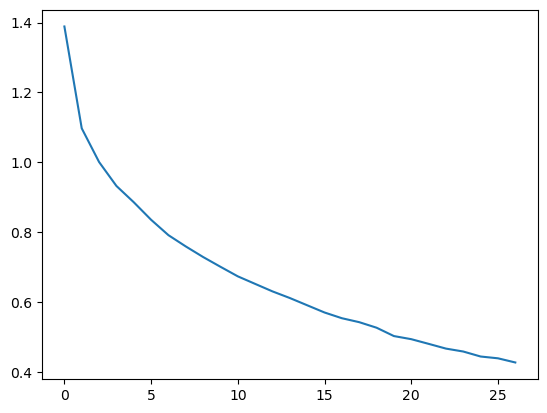

In [61]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

## Visualization

The closer to 1, the higher number of guesses in language X given labels in language Y

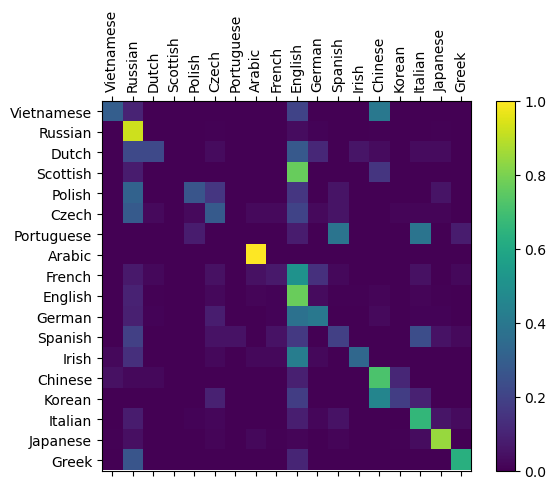

[PRECISION] 0.7937562271670542


In [65]:
import sklearn.metrics

def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn.forward(text_tensor)

            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

            y_true.append(label_i)
            y_pred.append(guess_i)

    # normalize by row
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) # numpy uses cpu
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    plt.show()

    precision = sklearn.metrics.accuracy_score(y_true, y_pred)
    print(f"[PRECISION] {precision}")


evaluate(rnn, test_set, classes=alldata.labels_uniq)

## References

https://docs.pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html